# Homework 3 Report - Alex Anderson and Dan Mossing
# Team Marcomentum

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import caffe

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
def get_split(split):
    filename = './development_kit/data/%s.txt' % split
    if not os.path.exists(filename):
        raise IOError('Split data file not found: %s' % split)
    return filename

def get_pred(base, source):
    return os.path.join(base, 'top_5_predictions.{}.csv'.format(source))

In [3]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [4]:
base_path = '/home/mossing/caffemodels_for_alex/*'

model_dirs = glob(base_path)

# Model Performance for different Architectures

We investigated a variety of different alex-net like architectures. In particular, we tried making the network deeper by adding convolutional layers and making the network skinnier by reducing the numbers and sizes of filters in each layer. Overall, our results showed that making a deeper network improved performance above the baseline by about 7 percentage points. Network parameters were as follows:

Standard

Filter sizes: [11, 5, 3, 3, 3]

Filter numbers: [96, 256, 384, 384, 1024]

Skinny

Filter sizes: [11, 5, 3, 3, 3, 3]

Filter numbers: [48, 128, 192, 192, 192, 128]


Skinny Fat

Filter sizes: [11, 5, 3, 3, 3]

Filter numbers: [72, 192, 288, 288, 192]

Deeper

Filter sizes: [7, 5, 3, 3, 3]

Filter numbers: [64, 112, 192, 320, 512]

Even Deeper

Filter sizes: [7, 5, 3, 3, 3, 3]

Filter numbers: [64, 112, 192, 192, 320, 512]

Different Deeper

Filter sizes: [7, 5, 3, 3, 3, 3]

Filter numbers: [64, 112, 152, 192, 256, 320]

Too Deep

Filter sizes: [7, 5, 3, 3, 3, 3, 3]

Filter numbers: [64, 112, 192, 192, 192, 320, 512]

Although the deepest networks were substantially better in training error, their test error showed more modest improvement. "Deeper", "Even Deeper", and "Too Deep" were equivalent in test error, despite a difference of two convolutional layers. Even though the bottom layer filters appeared noisy for the amount of training data available, simply reducing their number (as in the case of "Skinny Fat") did not improve performance, even at greater depth ("Skinny"). The most substantial improvement in performance we observed was in scaling down filter sizes and numbers proportionally across all layers (as in going from "Skinny Fat" to "Deeper"). 

In [5]:
for split in ['train', 'val']:
    data = pd.read_csv(get_split(split), sep=' ', header=None, names=['image', 'true_label'])
    for q, model_dir in enumerate(model_dirs):
        name = model_dir.split('/')[-1]
        print 'Model name: {}'.format(name)
#         print 'Split: {}'.format(split)
        tmp = ['{}label{}'.format(name, i) for i in [1,2,3,4,5]]
        pred = pd.read_csv(get_pred(model_dir, split), header=True, names=(['image'] + tmp))
        data = pd.merge(data, pred, on='image')

        top1 = (data['true_label'] == data['{}label1'.format(name)]).mean()
        print 'Split: {:6}, Top 1 accuracy: {:.2f} %'.format(split, top1 * 100)

Model name: skinny
Split: train , Top 1 accuracy: 38.57 %
Model name: deeper
Split: train , Top 1 accuracy: 49.83 %
Model name: skinny_fat
Split: train , Top 1 accuracy: 41.08 %
Model name: too_deep
Split: train , Top 1 accuracy: 53.06 %
Model name: diff_deeper
Split: train , Top 1 accuracy: 52.55 %
Model name: even_deeper
Split: train , Top 1 accuracy: 55.07 %
Model name: skinny
Split: val   , Top 1 accuracy: 31.47 %
Model name: deeper
Split: val   , Top 1 accuracy: 39.75 %
Model name: skinny_fat
Split: val   , Top 1 accuracy: 33.22 %
Model name: too_deep
Split: val   , Top 1 accuracy: 40.05 %
Model name: diff_deeper
Split: val   , Top 1 accuracy: 40.03 %
Model name: even_deeper
Split: val   , Top 1 accuracy: 40.28 %


# Plot the first layer filters

In order to investigate the convergence of our network, we are visualizing the filters in the first layer. We can see that we get a number of gray scale filters that pick out different frequency components and we get some color opponent channels. It is evident that the colors are present at lower frequencies in the image (due to jpeg compression). It seems like the features are much more noisy compared to the filters generated by CNNs trained on larger datasets. Perhaps more data or stronger weight decay could result in filters that were less noisy. It is also interesting to note that many of the filter banks are quantitatively very similar, likely due to the shared initialization scheme. Altering the initializations would be an interesting direction for the future.

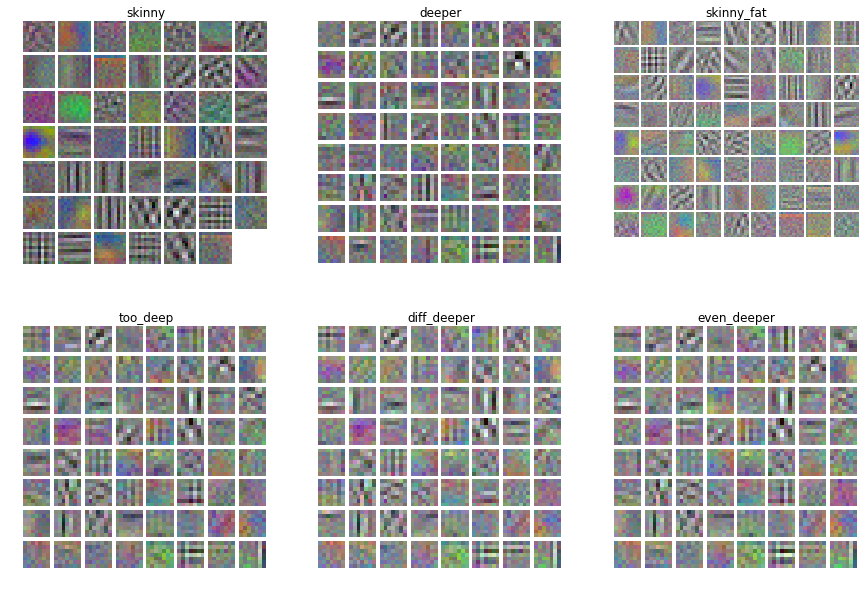

In [6]:
plt.figure(figsize=(15, 10))
for i, model_dir in enumerate(model_dirs):
    proto_fn = glob(model_dir + '/*proto*')[0]
    model_fn = glob(model_dir + '/snapshot/*50000.caffemodel')[0]

    net = caffe.Net(proto_fn, model_fn, caffe.TEST)

    plt.subplot(2, 3, i+1)
    plt.title(model_dir.split('/')[-1])
    filters = net.params['conv0'][0].data
    vis_square(filters.transpose(0, 2, 3, 1))

# Confusion Matrix

Here, we look at the confusion matrix and identify the hardest categories to classify for the trained model that performed the best on the validation set. 

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
cm = confusion_matrix(data['true_label'], data['even_deeperlabel1'])

Looking at the confusion matrix, we see that most of the weight is along the diagonal, as expected.

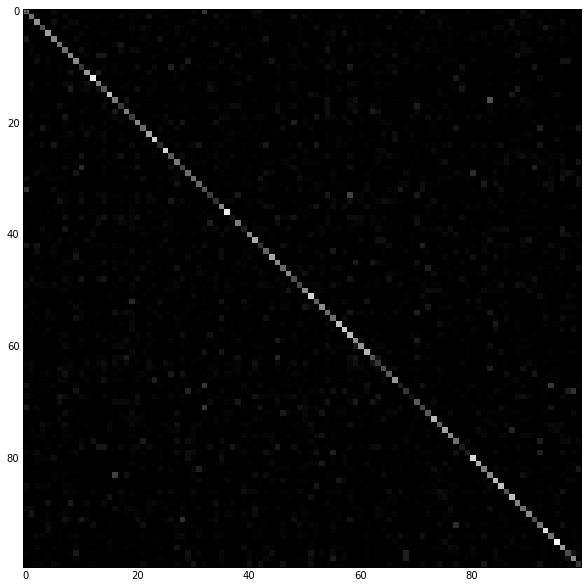

In [19]:
plt.imshow(cm)

To get a sense for what the brightest off-diagonal elements are:

In [47]:
msk = np.ones(cm.shape)
np.fill_diagonal(msk,0)
arr = cm*msk
ind = np.argpartition(arr.flatten(), -5)[-5:] # find the 5 largest off diagonal indices
el1 = np.divide(ind,100)
el2 = np.remainder(ind,100)
confused = [[cat['category'][el[0]], cat['category'][el[1]]] for el in zip(el1,el2)]
confused # pairs of place categories corresponding to the most common misclassifications

[['/m/monastery/outdoor', '/c/church/outdoor'],
 ['/p/palace', '/c/church/outdoor'],
 ['/b/bathroom', '/s/shower'],
 ['/c/classroom', '/k/kindergarden_classroom'],
 ['/s/shower', '/b/bathroom']]

Clearly, there are strong visual similarities (or even ambiguities) between each of these pairs of places. On the top end, there were certain categories that were very reliably classified (although unlikely to be close to human performance). 

In [55]:
cat = pd.read_csv('development_kit/data/categories.txt', 
                  sep=' ', header=None, names=['category', 'label'])
cat['val_correct'] = np.diag(cm) / (1. * cm.shape[0])

In [56]:
print cat.sort('val_correct').head(10)

                category  label  val_correct
69      /m/museum/indoor     69         0.06
37        /c/coffee_shop     37         0.07
78         /r/restaurant     78         0.09
79              /r/river     79         0.10
67  /m/monastery/outdoor     67         0.10
39  /c/construction_site     39         0.10
24             /b/bridge     24         0.13
34     /c/clothing_store     34         0.16
42          /c/courtyard     42         0.17
10        /b/bakery/shop     10         0.18


Looking at two categories that are at chance for top 1, indoor museum and river, we see some reasonable errors. For instance, the indoor museum gets misclassified as a lobby, art gallery, and a bookstore. Likewise, the river gets miscategorized as a swamp, hot spring, harbor, and rainforest. 

In [57]:
cat['mus_ind_error'] = cm[69] / 100.
cat.sort('mus_ind_error').tail()

,category,label,val_correct,mus_ind_error
89,/s/staircase,89,0.37,0.05
20,/b/bookstore,20,0.45,0.05
69,/m/museum/indoor,69,0.06,0.06
6,/a/art_gallery,6,0.39,0.07
63,/l/lobby,63,0.18,0.07


In [58]:
cat['river_error'] = cm[79] / 100.
cat.sort('river_error').tail()

,category,label,val_correct,mus_ind_error,river_error
77,/r/rainforest,77,0.37,0,0.06
52,/h/harbor,52,0.32,0,0.06
79,/r/river,79,0.10,0,0.10
55,/h/hot_spring,55,0.36,0,0.10
92,/s/swamp,92,0.38,0,0.11


In [59]:
print cat.sort('val_correct').tail(10)

                    category  label  val_correct  mus_ind_error  river_error
15         /b/baseball_field     15         0.65           0.01         0.00
57                /i/iceberg     57         0.67           0.00         0.01
23            /b/boxing_ring     23         0.69           0.02         0.00
51            /g/golf_course     51         0.70           0.00         0.01
25           /b/bus_interior     25         0.71           0.00         0.00
80              /r/rock_arch     80         0.72           0.00         0.01
93  /s/swimming_pool/outdoor     93         0.74           0.01         0.00
36                /c/cockpit     36         0.78           0.00         0.01
12          /b/bamboo_forest     12         0.80           0.00         0.00
95          /t/track/outdoor     95         0.85           0.00         0.00


In the case of the golf course, confused categories are enriched for grassy outdoor scenes.

In [60]:
cat['golf_error'] = cm[51] / 100.
cat.sort('golf_error').tail()

,category,label,val_correct,mus_ind_error,river_error,golf_error
30,/c/cemetery,30,0.36,0,0.03,0.03
97,/v/valley,97,0.25,0,0.00,0.03
92,/s/swamp,92,0.38,0,0.11,0.04
71,/p/palace,71,0.23,0,0.01,0.04
51,/g/golf_course,51,0.70,0,0.01,0.70
